In [1]:
! rm /etc/localtime
! ln -s /usr/share/zoneinfo/Asia/Hong_Kong /etc/localtime
! dpkg-reconfigure tzdata


Current default time zone: 'Asia/Hong_Kong'
Local time is now:      Thu May 28 00:00:29 HKT 2020.
Universal Time is now:  Wed May 27 16:00:29 UTC 2020.



In [2]:
! sudo lsb_release -a
! echo
! /opt/bin/nvidia-smi

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [3]:
! pip install ipython-autotime

% load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=5071a6005516e42ef1c7bdee188edf33126a1882b8355a0bdde9d6ccac63981e
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
! wget http://images.cocodataset.org/zips/train2017.zip

--2020-05-28 00:01:07--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.239.171
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.239.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.6MB/s    in 5m 42s  

2020-05-28 00:06:50 (53.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

time: 5min 43s


In [6]:
! unzip "train2017.zip" >/dev/null 2>&1

time: 6min 8s


In [7]:
import os

path = "train2017"

files = os.listdir(path)

paths = []

for file in os.listdir(path):
     if not os.path.isdir(file):
          paths.append(path + "/" + file)

train_count = len(files)
print(train_count)

118287
time: 981 ms


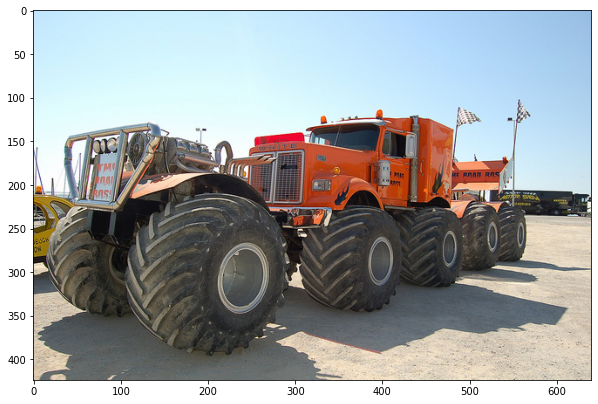

time: 1.39 s


In [8]:
from skimage.io import imread
import matplotlib.pyplot as plt

image = imread(paths[0])

plt.figure(figsize=(10, 15))
plt.imshow(image)
plt.show()

In [9]:
image.shape

(424, 640, 3)

time: 5.58 ms


In [10]:
! pip install -U --pre efficientnet

time: 5.76 s


In [11]:
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize, preprocess_input
from keras.applications.imagenet_utils import decode_predictions

import numpy as np

model = efn.EfficientNetB7(weights='imagenet') 

Using TensorFlow backend.


268320768/268317848 [==============================] - 3s 0us/step
time: 22 s


In [12]:
# preprocess input
image_size = model.input_shape[1]
x = center_crop_and_resize(image, image_size=image_size)
x = preprocess_input(x)
x = np.expand_dims(x, 0)

# make prediction and decode
y = model.predict(x)
decode_predictions(y)

40960/35363 [==================================] - 0s 0us/step


[[('n04465501', 'tractor', 0.55817425),
  ('n03496892', 'harvester', 0.069206335),
  ('n04252225', 'snowplow', 0.056381933),
  ('n03967562', 'plow', 0.017978761),
  ('n03384352', 'forklift', 0.014656907)]]

time: 12.9 s


In [13]:
model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 600, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 300, 300, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 300, 300, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 300, 300, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [14]:
for i, layer in enumerate(model.layers):
    continue
    print("%3d: %s" % (i, layer.name))

time: 1.57 ms


In [15]:
from keras import backend as K

get_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                              [model.layers[49].output,   #  49: block1d_add
                               model.layers[152].output,  # 152: block2g_add
                               model.layers[255].output,  # 255: block3g_add
                               model.layers[403].output,  # 403: block4j_add
                               model.layers[551].output,  # 551: block5j_add
                               model.layers[744].output,  # 744: block6m_add
                               model.layers[802].output,  # 802: block7d_add
                               model.layers[808].output,  # 808: probs
                               ])


# preprocess input
image_size = model.input_shape[1]
x = center_crop_and_resize(image, image_size=image_size)
x = preprocess_input(x)
x = np.expand_dims(x, 0)

# output in test mode = 0
layer_output = get_layer_output([x, 0])

# output in train mode = 1
# layer_output = get_layer_output([x, 1])

time: 12.8 s


In [16]:
decode_predictions(layer_output[-1])

[[('n04465501', 'tractor', 0.55817425),
  ('n03496892', 'harvester', 0.069206335),
  ('n04252225', 'snowplow', 0.056381933),
  ('n03967562', 'plow', 0.017978761),
  ('n03384352', 'forklift', 0.014656907)]]

time: 4.04 ms


In [17]:
for i in range(8):
    print(layer_output[i].shape)

(1, 300, 300, 32)
(1, 150, 150, 48)
(1, 75, 75, 80)
(1, 38, 38, 160)
(1, 38, 38, 224)
(1, 19, 19, 384)
(1, 19, 19, 640)
(1, 1000)
time: 1.47 ms


In [18]:
def content_cost(C, G):
    m, h, w, c = C.shape
    
    C = C.reshape(m, -1, c)
    G = G.reshape(m, -1, c)

    J_content = np.sum((C - G) ** 2) / (4 * h * w * c)
    return J_content

time: 3.87 ms


In [19]:
def style_cost_layer(S, G):
    m, h, w, c = S.shape

    S = S.T.reshape(c, h * w)
    G = G.T.reshape(c, h * w)

    GS = np.matmul(S, S.T)
    GG = np.matmul(G, G.T)

    J_style_layer = np.sum((GS - GG) ** 2) / (2 * h * w * c) ** 2
    return J_style_layer

def style_cost(Ss, Gs):
    J_style = np.sum(style_cost_layer(Ss[i], Gs[i]) for i in range(len(Ss)))
    return J_style

time: 12.9 ms


In [20]:
def total_cost(Cs, Ss, Gs, alpha=10, beta=40):
    J_content = content_cost(Cs[-3], Gs[-3])
    J_style = style_cost(Ss[1:-3], Gs[1:-3])

    J = alpha * J_content + beta * J_style
    return J

time: 3.26 ms


In [21]:
class Cost(object):
    def __init__(self, style, model):
        self.model = model
        self.get_layer_output = K.function([self.model.layers[0].input, K.learning_phase()],
                                           [self.model.layers[49].output,   #  49: block1d_add
                                            self.model.layers[152].output,  # 152: block2g_add
                                            self.model.layers[255].output,  # 255: block3g_add
                                            self.model.layers[403].output,  # 403: block4j_add
                                            self.model.layers[551].output,  # 551: block5j_add
                                            self.model.layers[744].output,  # 744: block6m_add
                                            self.model.layers[802].output,  # 802: block7d_add
                                            self.model.layers[808].output,  # 808: probs
                                            ])

        self.S_img = style
        self.Ss = self.get_outputs(self.S_img)

    def get_outputs(self, img):
        img_size = self.model.input_shape[1]
        x = center_crop_and_resize(img, image_size=img_size)
        x = preprocess_input(x)
        x = np.expand_dims(x, 0)
        out = self.get_layer_output([x, 0])
        return out

    def content_cost(self, C, G):
        m, h, w, c = C.shape

        C = C.reshape(m, -1, c)
        G = G.reshape(m, -1, c)

        J_content = np.sum((C - G) ** 2) / (4 * h * w * c)
        return J_content

    def style_cost(self, Ss, Gs):
        def style_cost_layer(S, G):
            m, h, w, c = S.shape

            S = S.T.reshape(c, h * w)
            G = G.T.reshape(c, h * w)

            GS = np.matmul(S, S.T)
            GG = np.matmul(G, G.T)

            J_style_layer = np.sum((GS - GG) ** 2) / (2 * h * w * c) ** 2
            return J_style_layer

        J_style = sum(style_cost_layer(Ss[i], Gs[i]) for i in range(len(Ss)))
        return J_style

    def cost(self, content, generation, alpha=10, beta=40):
        Cs = self.get_outputs(content)
        Gs = self.get_outputs(generation)

        J_content = self.content_cost(Cs[-3], Gs[-3])
        J_style = self.style_cost(self.Ss[1:-3], Gs[1:-3])

        J = alpha * J_content + beta * J_style
        return J

time: 56.4 ms


In [22]:
t = Cost(image, model)

time: 12.5 s


In [23]:
t.cost(image, image)

0.0

time: 9.61 s


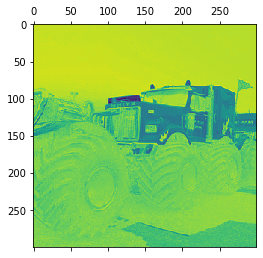

time: 141 ms


In [39]:
plt.matshow(layer_output[0][0, :, :, 4])
plt.show()

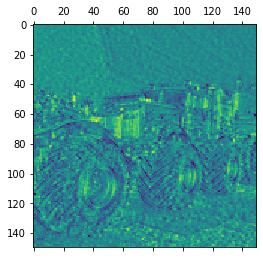

time: 131 ms


In [40]:
plt.matshow(layer_output[1][0, :, :, 4])
plt.show()

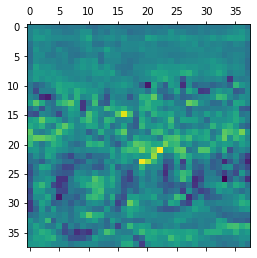

time: 117 ms


In [41]:
plt.matshow(layer_output[-4][0, :, :, 4])
plt.show()

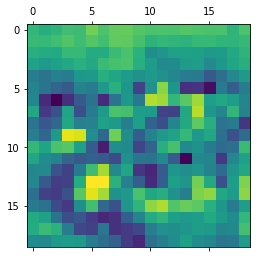

time: 430 ms


In [42]:
plt.matshow(layer_output[-3][0, :, :, 4])
plt.show()

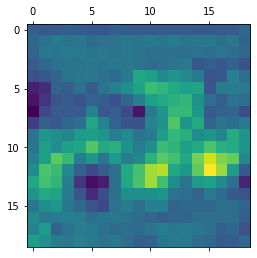

time: 105 ms


In [43]:
plt.matshow(layer_output[-2][0, :, :, 4])
plt.show()